In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.2.0


In [3]:
train_image_path = glob.glob('datasets/dc/train/*/*.jpg')

In [4]:
len(train_image_path)

2000

In [5]:
train_image_path[:5]

['datasets/dc/train\\cat\\cat.0.jpg',
 'datasets/dc/train\\cat\\cat.1.jpg',
 'datasets/dc/train\\cat\\cat.10.jpg',
 'datasets/dc/train\\cat\\cat.100.jpg',
 'datasets/dc/train\\cat\\cat.101.jpg']

In [6]:
train_image_path[-5:]

['datasets/dc/train\\dog\\dog.995.jpg',
 'datasets/dc/train\\dog\\dog.996.jpg',
 'datasets/dc/train\\dog\\dog.997.jpg',
 'datasets/dc/train\\dog\\dog.998.jpg',
 'datasets/dc/train\\dog\\dog.999.jpg']

In [7]:
p = 'dataseus/dc/train\\dog\\dog.995.jpg'

In [8]:
# 划分属于猫狗训练集
int(p.split('\\')[1] == 'cat')

0

In [9]:
# 得到相应的标签 0为狗 1 为猫
train_image_label = [int(p.split('\\')[1] == 'cat') for p in train_image_path]

In [10]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [1]:
def load_preprosess_image(path, label):
    image = tf.io.read_file(path)
    # 解码数据，channel默认是0 彩色为3
    image = tf.image.decode_jpeg(image, channels=3)
    # 统一把图像转换成360
    image = tf.image.resize(image, [360, 360])
    # 图像增强 随机裁剪图片大小
    image = tf.image.random_crop(image, [256, 256, 3])
    # 随机翻转 左右翻转
    image = tf.image.random_flip_left_right(image)
    # 随机翻转 上下翻转
    image = tf.image.random_flip_up_down(image)
    # 随机亮度 最大亮度为0.5
    image = tf.image.random_brightness(image, 0.5)
    # 随机对比度
    image = tf.image.random_contrast(image, 0, 1)
    # 图像转换数据类型同时进行归一化
    image = tf.cast(image, tf.float32)
    image = image/255
    label = tf.reshape(label, [1])
    return image, label

In [12]:
#[1, 2, 3]  -->  [[1], [2], [3]] 每个样本 作为单独维度

In [13]:
#tf.image.convert_image_dtype 如果元数据是float则不做归一化

In [14]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [15]:
# 根据计算机的性能使用CPU的个数
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [16]:
# 在处理的时候，让这个函数应用在所有图像上
train_image_ds = train_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [17]:
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

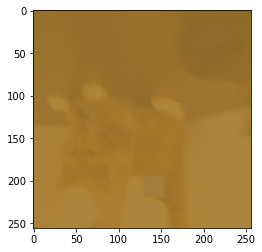

In [18]:
for img, label in train_image_ds.take(1):
    plt.imshow(img)

In [19]:
BATCH_SIZE = 16
train_count = len(train_image_path)

In [20]:
# 在train_count范围进行乱序
train_image_ds = train_image_ds.shuffle(train_count).batch(BATCH_SIZE)
# prefetch 在后台读取多少个数据 预处理一些数据，加速读取过程
train_image_ds = train_image_ds.prefetch(AUTOTUNE)

In [21]:
imgs,labels = next(iter(train_image_ds))

In [22]:
imgs.shape

TensorShape([16, 256, 256, 3])

In [23]:
test_image_path = glob.glob('datasets/dc/test/*/*.jpg')
test_image_label = [int(p.split('\\')[1] == 'cat') for p in test_image_path]
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))
test_image_ds = test_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.batch(BATCH_SIZE)
test_image_ds = test_image_ds.prefetch(AUTOTUNE)

In [24]:
len(test_image_path)

1000

In [25]:
labels.shape

TensorShape([16, 1])

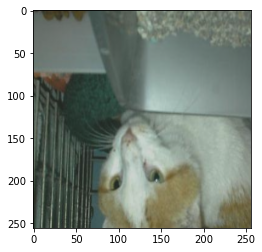

In [26]:
plt.imshow(imgs[0])

In [27]:
labels[0]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>

In [28]:
# 创建一个简单的模型
model = keras.Sequential([
#     # 第一层使用卷积层 64个卷积核，3，3
#     tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     # 池化层缩小
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),
#      tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
#     tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
#     tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(1)
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 512)       1

In [30]:
pred = model(imgs)

In [31]:
pred.shape

TensorShape([16, 1])

In [32]:
# 将预测结果浮点数组>0的情况转为int ，p[0]第一个纬度
# 没有训练的模型的结果
np.array([p[0].numpy() for p in tf.cast(pred > 0, tf.int32)])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
# 实际训练的结果
np.array([l[0].numpy() for l in labels])

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 自定义训练

In [34]:
# 由于我们续联的函数的没有使用sigmoid激活函数所以from_logits=TRUE,
ls = tf.keras.losses.BinaryCrossentropy()

In [35]:
# 第一个参数是真实值，第二个是预测值
ls([0.,0.,1.,1.], [1.,1.,1.,1.])

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [36]:
ls([[0.],[0.],[1.],[1.]], [[1.],[1.],[1.],[1.]])

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [37]:
tf.keras.losses.binary_crossentropy([0.,0.,1.,1.], [1.,1.,1.,1.])

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [38]:
optimizer = tf.keras.optimizers.Adam()

In [39]:
# 使用metric模块
epoch_loss_avg = tf.keras.metrics.Mean('train_loss')
train_accuracy = tf.keras.metrics.Accuracy()

epoch_loss_avg_test = tf.keras.metrics.Mean('test_loss')
test_accuracy = tf.keras.metrics.Accuracy()

In [40]:
train_accuracy([1,0,1], [1,1,1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.6666667>

In [41]:
def train_step(model, images, labels):
    # 创建一个上下文管理器
    with tf.GradientTape() as t:
        #记录运算过程
        pred = model(images)
        # 损失值
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred)
    # loss与可训练参数的梯度
    grads = t.gradient(loss_step, model.trainable_variables)
    # 根据梯度进行优化
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    epoch_loss_avg(loss_step)
    # pre>0然后转成int 然后转成0,1
    train_accuracy(labels, tf.cast(pred>0, tf.int32))

In [42]:
def test_step(model, images, labels):
    pred = model(images, trianing=False)
    loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred)
    epoch_loss_avg_test(loss_step)
    test_accuracy(labels, tf.cast(pred>0, tf.int32))

In [43]:
# 创建空列表
train_loss_results = []
train_acc_results = []

test_loss_results = []
test_acc_results = []

In [46]:
num_epochs = 8

In [47]:
for epoch in range(num_epochs):
    for imgs_, labels_ in train_image_ds:
        train_step(model, imgs_, labels_)
        print('.', end='')
    print()
    # 通过result进行取结果
    train_loss_results.append(epoch_loss_avg.result())
    train_acc_results.append(train_accuracy.result())
    
    
    for imgs_, labels_ in test_image_ds:
        test_step(model, imgs_, labels_)
        
    test_loss_results.append(epoch_loss_avg_test.result())
    test_acc_results.append(test_accuracy.result())
    
    print('Epoch:{}: loss: {:.3f}, accuracy: {:.3f}, test_loss: {:.3f}, test_accuracy: {:.3f}'.format(
        epoch + 1,# 从1开始
        epoch_loss_avg.result(),
        train_accuracy.result(),
        epoch_loss_avg_test.result(),
        test_accuracy.result()
    ))
    
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()

...................

KeyboardInterrupt: 